In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pyproj
from scipy.interpolate import griddata
import cftime
from sklearn.linear_model import LinearRegression
import cartopy.feature as cfeature

In [2]:
home_path = os.path.expanduser("~")

path = '/DataFiles'
path2 = '/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - MacBook Air/Python/Ice Cores/data/model/ccsm4_last_millenium'

racmo = xr.open_dataset(home_path + path + "/smb_monthlyS_ANT27_ERA5-3H_RACMO2.3p2_197901_202212.nc")
mask = xr.open_dataset(home_path + path + "/TotIS_RACMO_ANT27_IMBIE2.nc")

In [3]:
# Extract coordinate arrays
lat_attr = np.array(mask.GroundedIce.attrs["lat2d"])
lon_attr = np.array(mask.GroundedIce.attrs["lon2d"])

# Reshape to 2D
nlat, nlon = mask.dims["lat"], mask.dims["lon"]
lats2d = lat_attr.reshape(nlat, nlon)
lons2d = lon_attr.reshape(nlat, nlon)

# Attach as coordinates
basins = mask["GroundedIce"].copy()
basins = basins.assign_coords(lat=(("lat", "lon"), lats2d),
                              lon=(("lat", "lon"), lons2d))

/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_16836/630878015.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nlat, nlon = mask.dims["lat"], mask.dims["lon"]


/opt/anaconda3/envs/cfr-env/lib/python3.13/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/cfr-env/lib/python3.13/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)


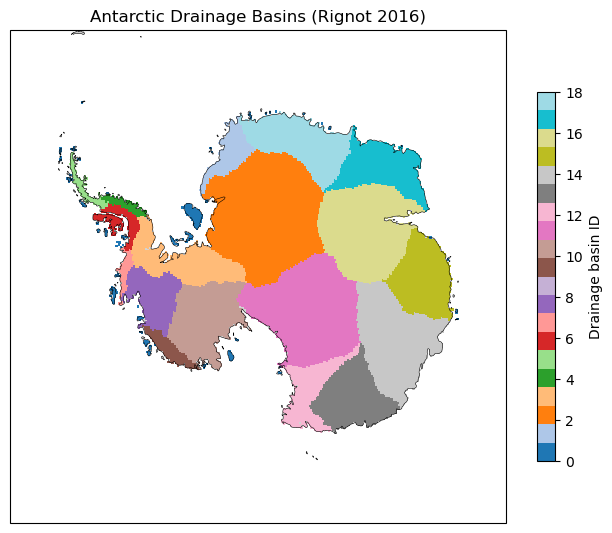

In [4]:
proj = ccrs.SouthPolarStereo()
data_crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': proj})
ax.set_extent([-180, 180, -90, -60], crs=data_crs)

ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Filled basins
im = ax.pcolormesh(
    basins.lon, basins.lat, basins,
    transform=data_crs,
    cmap='tab20'
)


plt.colorbar(im, ax=ax, shrink=0.6, label="Drainage basin ID")
ax.set_title("Antarctic Drainage Basins (Rignot 2016)", fontsize=12)
plt.show()

In [ ]:
smb = racmo["smb"].squeeze("height")
smb_total = smb.groupby("time.year").sum(dim="time")
smb_ann = smb_total.sel(year=slice(1979, 2000))

basin_mask = mask["GroundedIce"]  # (lat, lon)
basin_mask = basin_mask.where(basin_mask != 0)  # ignore 0/non-grounded ice

basin_mask_aligned = mask["GroundedIce"].rename({"lat": "rlat", "lon": "rlon"})


n_years = smb_ann.sizes["year"]
nlat, nlon = smb_ann.sizes["rlat"], smb_ann.sizes["rlon"]

smb_flat = smb_ann.values.reshape(n_years, nlat*nlon)  # shape: (22, 240*262)
basin_flat = mask["GroundedIce"].values.reshape(nlat*nlon)  # shape: (240*262,)

valid_mask = ~np.isnan(basin_flat) & (basin_flat != 0)
basin_ids = basin_flat[valid_mask].astype(int)

smb_df = pd.DataFrame(smb_flat[:, valid_mask].T, index=basin_ids)

annual_smb_per_basin = smb_df.groupby(smb_df.index).sum()
annual_smb_per_basin = annual_smb_per_basin.T

# Extract lat/lon arrays
lat = racmo["lat"].values
lon = racmo["lon"].values

# Define Antarctic polar stereographic projection
# Parameters from standard EPSG:3031
proj = pyproj.Proj(proj='stere', lat_0=-90, lon_0=0, lat_ts=-71, ellps='WGS84')

# Project the 2D grid
x, y = proj(lon, lat)  # x, y in meters, shape = (rlat, rlon)

# Differences along axes
dx = np.diff(x, axis=1)  # differences along rlon (columns), shape (rlat, rlon-1)
dy = np.diff(y, axis=0)  # differences along rlat (rows), shape (rlat-1, rlon)

# Approximate cell area as dx * dy
# Take inner product to match shapes: (rlat-1, rlon-1)
cell_area = dx[:-1, :] * dy[:, :-1]

# Convert to xarray DataArray
cell_area_da = xr.DataArray(cell_area, dims=("rlat","rlon"))

# cell_area_da shape: (239, 261)
area = cell_area_da.values

# Duplicate last row
area_full = np.vstack([area, area[-1:, :]])  # shape: (240, 261)

# Duplicate last column
area_full = np.hstack([area_full, area_full[:, -1:]])  # shape: (240, 262)

# Convert back to DataArray with original dims
cell_area_da_full = xr.DataArray(area_full, dims=("rlat","rlon"))
print(cell_area_da_full.shape)  # (240, 262)

smb_1979 = smb_ann.sel(year=1979)  # shape (240, 262), kg/m²

# Mass per grid cell in kg
smb_mass_1979 = smb_1979 * cell_area_da_full

# Antarctic-wide total in Gt
antarctic_smb_Gt = smb_mass_1979.sum() / 1e12
print("Total Antarctic SMB 1979 [Gt]:", antarctic_smb_Gt.values)




In [25]:
# Select SMB and annual sum
smb = racmo["smb"].squeeze("height")
smb_ann = smb.groupby("time.year").sum(dim="time").sel(year=slice(1979, 2000))

# Antarctic-wide cell area calculation
lat = racmo["lat"].values
lon = racmo["lon"].values
proj = pyproj.Proj(proj='stere', lat_0=-90, lon_0=0, lat_ts=-71, ellps='WGS84')
x, y = proj(lon, lat)

dx = np.diff(x, axis=1)
dy = np.diff(y, axis=0)
cell_area = dx[:-1, :] * dy[:, :-1]

# Duplicate last row/column to match original grid
cell_area_full = np.vstack([cell_area, cell_area[-1:, :]])
cell_area_full = np.hstack([cell_area_full, cell_area_full[:, -1:]])
cell_area_da = xr.DataArray(cell_area_full, dims=("rlat","rlon"))

# Compute Antarctic-wide SMB in Gt for all years
smb_mass_ann = smb_ann * cell_area_da
antarctic_smb_Gt_ann = smb_mass_ann.sum(dim=("rlat","rlon")) / 1e12

print(antarctic_smb_Gt_ann)


<xarray.DataArray (year: 22)> Size: 176B
array([2350.08277372, 2521.93503009, 2700.15484852, 2629.46994877,
       2470.66199006, 2691.9616413 , 2629.19381388, 2448.53934351,
       2308.20739709, 2469.27427135, 2475.86211904, 2392.53517641,
       2529.72602602, 2687.8609197 , 2571.68004968, 2328.99397002,
       2449.51715504, 2500.87693916, 2398.12926555, 2585.07679908,
       2481.83424579, 2443.06221118])
Coordinates:
    height   float64 8B 0.0
  * year     (year) int64 176B 1979 1980 1981 1982 1983 ... 1997 1998 1999 2000


TypeError: Dimensions of C (240, 240) should be one smaller than X(262) and Y(241) while using shading='flat' see help(pcolormesh)

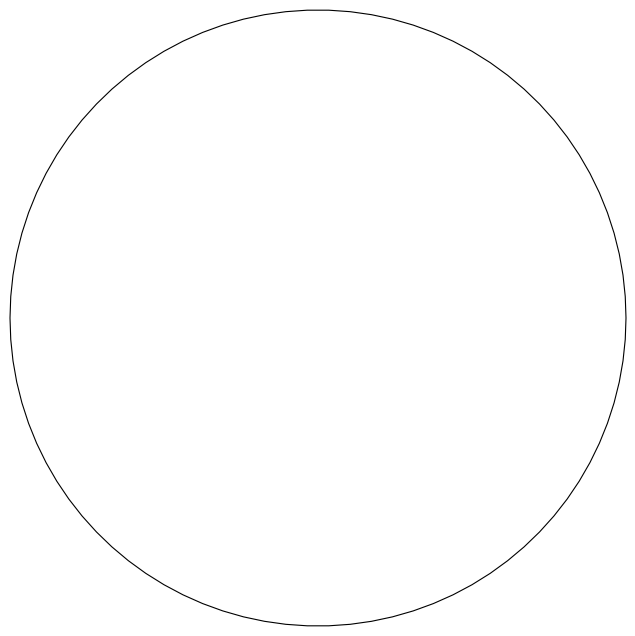

In [51]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Antarctic polar stereographic projection
proj = ccrs.SouthPolarStereo()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": proj})

# Plot cell area
# Convert to km² for readability
im = ax.pcolormesh(lon, lat, cell_area_da.values / 1e6, transform=ccrs.PlateCarree(), cmap="viridis")
cbar = plt.colorbar(im, ax=ax, orientation="vertical", label="Cell area [km²]")

# Add coastlines and features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor="lightgrey")
ax.gridlines(draw_labels=True)

ax.set_title("Antarctic Grid Cell Area")
plt.show()


In [33]:
print(racmo["lat"][100, 100])

<xarray.DataArray 'lat' ()> Size: 8B
array(-80.78535)
Coordinates:
    lat      float64 8B -80.79
    lon      float64 8B -113.0
    rlat     float64 8B -5.0
    rlon     float64 8B -7.75
Attributes:
    long_name:  latitude
    units:      degrees_north


In [41]:
import numpy as np
import xarray as xr
from pyproj import Geod

# -------------------------------
# 1. Select SMB and annual sums
# -------------------------------
smb = racmo["smb"].squeeze("height")
smb_ann = smb.groupby("time.year").sum(dim="time").sel(year=slice(1979, 2000))

lat = racmo["lat"].values  # shape (rlat, rlon)
lon = racmo["lon"].values

nlat, nlon = lat.shape
cell_area = np.zeros((nlat-1, nlon-1))  # one less along each axis for cell corners

geod = Geod(ellps="WGS84")

# -------------------------------
# 2. Compute accurate cell areas
# -------------------------------
for i in range(nlat-1):
    for j in range(nlon-1):
        # corners of the cell
        lons = [lon[i,j], lon[i,j+1], lon[i+1,j+1], lon[i+1,j]]
        lats = [lat[i,j], lat[i,j+1], lat[i+1,j+1], lat[i+1,j]]
        _, _, area = geod.polygon_area_perimeter(lons, lats)
        cell_area[i,j] = abs(area)  # m²

# Duplicate last row/column to match grid shape
cell_area_full = np.vstack([cell_area, cell_area[-1,:]])
cell_area_full = np.hstack([cell_area_full, cell_area_full[:,-1][:,None]])
cell_area_da = xr.DataArray(cell_area_full, dims=("rlat","rlon"))

# -------------------------------
# 3. Multiply SMB by cell area to get mass (kg)
# -------------------------------
smb_mass_ann = smb_ann * cell_area_da

# -------------------------------
# 4. Antarctic-wide SMB per year (Gt)
# -------------------------------
antarctic_smb_Gt_ann = smb_mass_ann.sum(dim=("rlat","rlon")) / 1e12

print(antarctic_smb_Gt_ann)


ValueError: not enough values to unpack (expected 3, got 2)

In [43]:
from pyproj import Geod
geod = Geod(ellps="WGS84")

lons = [lon[i,j], lon[i,j+1], lon[i+1,j+1], lon[i+1,j]]
lats = [lat[i,j], lat[i,j+1], lat[i+1,j+1], lat[i+1,j]]

# Correct unpacking for recent pyproj (>3.x)
area, perimeter = geod.polygon_area_perimeter(lons, lats)

cell_area[i,j] = abs(area)  # in m²



In [44]:
cell_area = np.zeros((nlat-1, nlon-1))

for i in range(nlat-1):
    for j in range(nlon-1):
        lons = [lon[i,j], lon[i,j+1], lon[i+1,j+1], lon[i+1,j]]
        lats = [lat[i,j], lat[i,j+1], lat[i+1,j+1], lat[i+1,j]]
        area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_area[i,j] = abs(area)


In [46]:
# Duplicate last row/column to match original grid
cell_area_full = np.vstack([cell_area, cell_area[-1:, :]])
cell_area_full = np.hstack([cell_area_full, cell_area_full[:, -1:]])
cell_area_da = xr.DataArray(cell_area_full, dims=("rlat","rlon"))

In [50]:
import numpy as np
import xarray as xr
import pyproj

# Select SMB and annual sum
smb = racmo["smb"].squeeze("height")
smb_ann = smb.groupby("time.year").sum(dim="time").sel(year=slice(1979, 2000))

lat = racmo["lat"].values  # shape (rlat, rlon)
lon = racmo["lon"].values

# Convert to polar stereographic projection (meters)
proj = pyproj.Proj(proj='stere', lat_0=-90, lon_0=0, lat_ts=-71, ellps='WGS84')
x, y = proj(lon, lat)

# Compute dx along columns (x-direction) and dy along rows (y-direction)
dx = np.diff(x, axis=1)  # shape (rlat, rlon-1)
dy = np.diff(y, axis=0)  # shape (rlat-1, rlon)

# Average dx and dy per latitude
dx_lat = dx.mean(axis=1)        # one dx per latitude, shape (rlat,)
dy_lat = dy.mean(axis=1)        # one dy per latitude, shape (rlat-1,)

# Create 2D area array by outer product
cell_area = np.outer(dy_lat, dx_lat[:-1])  # shape (rlat-1, rlon-1)

# Duplicate last row/column to match grid
cell_area_full = np.vstack([cell_area, cell_area[-1,:]])
cell_area_full = np.hstack([cell_area_full, cell_area_full[:,-1][:,None]])

cell_area_da = xr.DataArray(cell_area_full, dims=("rlat","rlon"))

# Multiply SMB by cell area
smb_mass_ann = smb_ann * cell_area_da

# Antarctic-wide SMB per year (Gt)
antarctic_smb_Gt_ann = smb_mass_ann.sum(dim=("rlat","rlon")) / 1e12
print(antarctic_smb_Gt_ann)


AlignmentError: cannot reindex or align along dimension 'rlon' because of conflicting dimension sizes: {240, 262} (note: an index is found along that dimension with size=262)